# Mean reverting startegy based on Bollinger bands Strategy

This notebook answers question 3.5 form the text book Advances in Financial Machine Learning.

3.5 Develop a mean-reverting strategy based on Bollinger bands. For each observation, the model suggests a side, but not a size of the bet.

* (a) Derive meta-labels for ptSl = [0, 2] and t1 where numDays = 1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
* (b) Train a random forest to decide whether to trade or not. Use as features: volatility, seial correlation, and teh crossinmg moving averages.
* (c) What is teh accuracy of prediction from the primary model? (i.e. if the secondary model does not filter the bets) What are the precision, recall and FI-scores?
* (d) What is teh accuracy of prediction from the primary model? What are the precision, recall and FI-scores?


In [82]:
import numpy as np
import pandas as pd
import pyfolio as pf
import timeit

from statsmodels.tsa.stattools import adfuller

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

from mlfinlab.corefns.core_functions import CoreFunctions
from mlfinlab.corefns.financial_functions import FinancialFunctions
from mlfinlab.fracdiff.fracdiff import frac_diff_ffd

import matplotlib.pyplot as plt
%matplotlib inline

### Read in Data
We are using the dollar bars based off of the high quality HFT data we purchased. There is a sample of bars available in this branch as well. 

In [83]:
# Read in data
data = pd.read_csv('official_data/dollar_bars.csv')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [84]:
data = data['2011-09-01':'2018-01-01']

---
### Define helper functions

In [85]:
# Compute RSI
def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = FinancialFunctions.relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

---
### Fit a Primary Model: Mean-reverting based on Bollinger bands
Based on the mean-reverting Bollinger band strategy.


In [86]:
# compute bands
window = 50
data['avg'], data['upper'], data['lower'] = FinancialFunctions.bbands(data['close'], window, no_of_stdev=2)
data.sample(10)

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower
date_time,,,,,,,,,,
2013-06-25 13:30:38.916,1581.00,1582.50,1579.75,1579.75,44399,70205864.25,10824,1567.355,1583.122795,1551.587205
2016-08-30 13:48:28.350,2177.50,2179.25,2177.25,2178.75,32136,70001687.00,3571,2176.685,2185.645691,2167.724309
2016-11-14 17:20:23.945,2156.50,2156.50,2153.25,2154.25,32526,70086527.00,4371,2161.205,2169.846789,2152.563211
2017-03-08 20:09:50.747,2366.50,2368.25,2366.25,2367.75,29613,70104969.00,2792,2368.115,2372.865091,2363.364909
2012-01-06 20:51:59.701,1274.50,1275.00,1272.50,1272.75,55121,70219152.75,12722,1272.685,1280.333403,1265.036597
2017-09-22 19:57:36.324,2500.00,2501.00,2499.50,2500.50,27999,70005870.00,2450,2498.575,2503.258068,2493.891932
2017-05-17 11:13:30.856,2383.50,2388.50,2383.25,2388.50,29433,70235144.00,3510,2396.345,2407.548994,2385.141006
2012-11-12 20:50:13.273,1377.00,1378.75,1376.25,1377.50,50820,70006436.00,11357,1378.895,1385.343453,1372.446547
2016-05-05 13:30:53.088,2050.25,2052.25,2049.50,2050.50,34133,70001196.25,4182,2046.440,2054.619467,2038.260533


In [87]:
# Compute frac diff
fracs = frac_diff_ffd(data['close'].apply(np.log), differencing_amt=0.10, threshold=1e-5)

result = adfuller(fracs, maxlag=2, regression='C', autolag='AIC', store=False, regresults=False)
print('ADF Statistic: %f' % abs(round(result[0], 3)))
print('p-value: %f' % result[1])
print('Critical values:')
for k, v in result[4].items():
    print('\t%s: %.3f' % (k, v))

ADF Statistic: 3.903000
p-value: 0.002016
Critical values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [88]:
frac_df = pd.Series(data=fracs, index=data.index)
frac_df.tail()
data['fracdiff'] = [frac_df[x] for x in data.index]

In [89]:
# Compute RSI
rsi_df = get_rsi(data, window=14)
data['rsi'] = pd.Series(data=rsi_df.values, index=data.index)

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

In [99]:
# data['side'] = compute_side(data)
long_signals = (data['close'] <= data['lower']) & (data['rsi'] <= 25)
short_signals = (data['close'] >= data['upper']) & (data['rsi'] >= 75) 
data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)


In [100]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

In [101]:
# print(data.sample(5))
print(data.side.value_counts())

-1.0    3555
 1.0    3428
Name: side, dtype: int64


### Filter Events: CUSUM Filter
Predict what will happen when a CUSUM event is triggered. Use the signal from the MAvg Strategy to determine the side of the bet.

In [93]:
# Compute daily volatility
daily_vol = CoreFunctions.get_daily_vol(close=data['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = CoreFunctions.get_t_events(data['close'], threshold=daily_vol.mean() * 0.1)

# Compute vertical barrier
vertical_barriers = CoreFunctions.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)

Calculating daily volatility for dynamic thresholds
Applying Symmetric CUSUM filter.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6983/6983 [00:01<00:00, 6927.45it/s]


In [94]:
pt_sl = [0, 2]
triple_barrier_events = CoreFunctions.get_events(close=data['close'],
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=0.01,
                                  num_threads=2,
                                  vertical_barrier_times=vertical_barriers,
                                  side=data['side'])

D:\Documents\WQU\Courses\14 - Capstone 690\chap3\research\Chapter3\mlfinlab\corefns\core_functions.py:205: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-03-07 21:30:11.144296 100.0% apply_pt_sl_on_t1 done after 0.04 minutes. Remaining 0.0 minutes.


In [95]:
labels = CoreFunctions.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

 1.0    856
-1.0    842
Name: side, dtype: int64

---
### Results of Primary Model:
What is the accuracy of predictions from the primary model (i.e., if the sec- ondary model does not filter the bets)? What are the precision, recall, and F1-scores?

In [63]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1445
           1       0.15      1.00      0.26       253

   micro avg       0.15      0.15      0.15      1698
   macro avg       0.07      0.50      0.13      1698
weighted avg       0.02      0.15      0.04      1698

Confusion Matrix
[[   0 1445]
 [   0  253]]

Accuracy
0.14899882214369847


---
## Fit a Meta Model
Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)

Create the following features: 
* Volatility
* Serial Correlation
* The returns at the different lags from the serial correlation
* The sides from the SMavg Strategy

In [64]:
raw_data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower,fracdiff,rsi,side
date_time,,,,,,,,,,,,,
2011-09-02 12:08:00.131,1191.75,1193.75,1189.75,1192.00,58751,70015084.25,19832,1212.455,1229.830414,1195.079586,0.0,11.0,NaN
2011-09-02 12:30:35.193,1192.00,1198.50,1182.00,1183.25,58894,70005676.00,18835,1211.720,1230.816597,1192.623403,0.0,7.0,1.0
2011-09-02 12:34:43.063,1183.50,1185.50,1179.75,1180.25,59197,70003214.75,17995,1211.010,1232.037184,1189.982816,0.0,6.0,1.0
2011-09-02 12:46:13.588,1180.25,1185.25,1179.75,1182.50,59181,70015589.25,20245,1210.460,1232.980594,1187.939406,0.0,6.0,1.0
2011-09-02 13:16:37.863,1182.50,1184.00,1180.25,1180.50,59208,70001715.00,21976,1209.820,1233.870763,1185.769237,0.0,6.0,1.0


### Features

In [65]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 7
slow_window = 15

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()


In [66]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = (raw_data['close'] <= raw_data['lower']) & (raw_data['rsi'] <= 25)
short_signals = (raw_data['close'] >= raw_data['upper']) & (raw_data['rsi'] >= 75) 

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [67]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

#### Now get the data at the specified events

In [68]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']
X.head()

,avg,upper,lower,fracdiff,rsi,side,log_ret,mom1,mom2,mom3,...,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5
2011-09-06 19:58:52.128,1149.345,1162.424385,1136.265615,0.0,75.0,-1.0,0.000645,0.000645,0.003667,0.004968,...,-0.372128,0.483882,-0.366536,0.114917,-0.576573,0.003015,0.001295,0.003462,-0.000650,0.000867
2011-09-06 20:10:24.430,1150.170,1164.474431,1135.865569,0.0,78.0,-1.0,-0.000429,-0.000429,0.001504,0.002151,...,-0.261291,0.385507,-0.281836,0.076816,-0.496466,0.001932,0.000645,0.003015,0.001295,0.003462
2011-09-07 06:49:33.590,1151.010,1166.499285,1135.520715,0.0,81.0,-1.0,0.004072,0.004081,0.003219,0.002789,...,-0.208932,0.322210,-0.125941,-0.082343,-0.302810,-0.000859,-0.000429,0.001932,0.000645,0.003015
2011-09-07 07:54:46.354,1151.555,1168.595555,1134.514445,0.0,89.0,-1.0,0.006397,0.006417,0.010524,0.009657,...,-0.129004,0.293137,-0.134276,-0.057213,-0.267518,0.004072,-0.000859,-0.000429,0.001932,0.000645
2011-09-07 08:36:06.996,1151.935,1170.056700,1133.813300,0.0,89.0,-1.0,-0.002341,-0.002338,0.004064,0.008162,...,-0.110341,0.211740,0.029460,-0.038646,-0.271445,0.006397,0.004072,-0.000859,-0.000429,0.001932


### Fit a model

In [69]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [70]:
# Random Forest Model
n_estimator = 50
c_random_state = 42
depth = 9

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#### Training Metrics

              precision    recall  f1-score   support

           0       0.91      1.00      0.96      1173
           1       1.00      0.41      0.58       185

   micro avg       0.92      0.92      0.92      1358
   macro avg       0.96      0.70      0.77      1358
weighted avg       0.93      0.92      0.90      1358

Confusion Matrix
[[1173    0]
 [ 110   75]]

Accuracy
0.14899882214369847


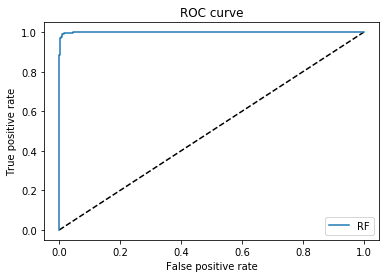

In [71]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

This is overfitting big time 

#### Test Metrics

c:\users\asingh\anaconda3\envs\cap\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.80      1.00      0.89       272
           1       0.00      0.00      0.00        68

   micro avg       0.80      0.80      0.80       340
   macro avg       0.40      0.50      0.44       340
weighted avg       0.64      0.80      0.71       340

Confusion Matrix
[[272   0]
 [ 68   0]]

Accuracy
0.14899882214369847


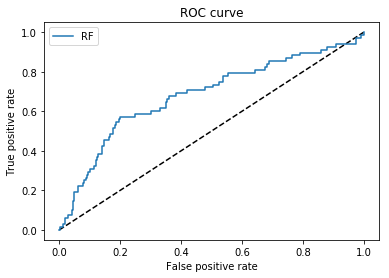

In [72]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

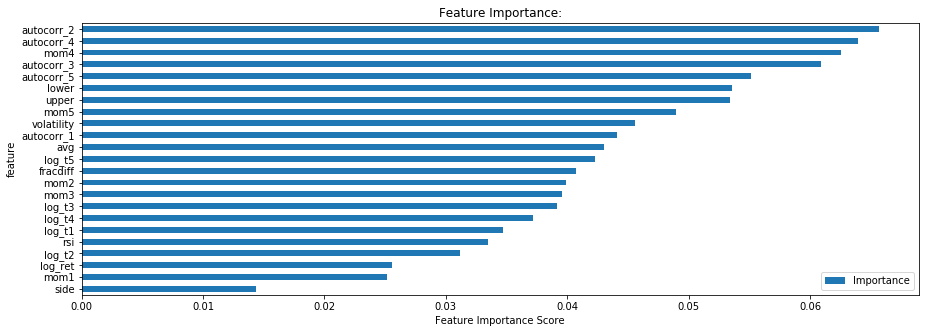

In [73]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

Note how low the side is ranked. If we look at the performance of the primary model we will see that the M-R strategy gets only 21% of the trades correct.

---
### Use PCA to shrink the predictor space

In [74]:
# standardize the data
scaler = StandardScaler()

# fit the training set only
scaler.fit(X_train)

# Apply the transform to both training and test sets
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

# make an instance of the PCA model with 95% coverage
pca = PCA(0.95)

# fit teh PCA model
pca.fit(X_train_std)
print(pca.n_components_)

# transform both training and test sets
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

13


### Training Metrics (PCA)

              precision    recall  f1-score   support

           0       0.90      1.00      0.94      1173
           1       1.00      0.26      0.41       185

   micro avg       0.90      0.90      0.90      1358
   macro avg       0.95      0.63      0.68      1358
weighted avg       0.91      0.90      0.87      1358

Confusion Matrix
[[1173    0]
 [ 137   48]]

Accuracy
0.14899882214369847


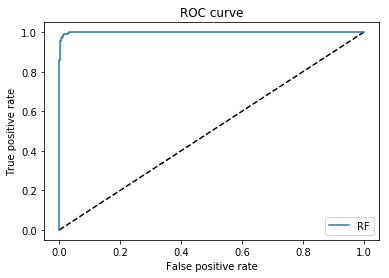

In [75]:
# Apply RF 
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train_pca, y_train.values.ravel())

# Performance Metrics
y_pred_rf = rf.predict_proba(X_train_pca)[:, 1]
y_pred = rf.predict(X_train_pca)

fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Test Metrics (PCA)

c:\users\asingh\anaconda3\envs\cap\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.80      1.00      0.89       272
           1       0.00      0.00      0.00        68

   micro avg       0.80      0.80      0.80       340
   macro avg       0.40      0.50      0.44       340
weighted avg       0.64      0.80      0.71       340

Confusion Matrix
[[272   0]
 [ 68   0]]

Accuracy
0.14899882214369847


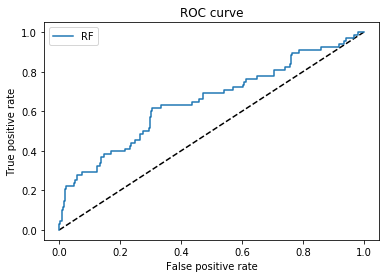

In [76]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test_pca)[:, 1]
y_pred = rf.predict(X_test_pca)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

---
## Performance Tear Sheets

In [77]:
test_dates = X_test.index

print(pf.show_perf_stats(labels.loc[test_dates, 'ret']))
print(pf.show_worst_drawdown_periods(labels.loc[test_dates, 'ret']))

Start date,2015-12-03
End date,2017-05-19
Total months,16
,Backtest
Annual return,106.1%
Cumulative returns,165.2%
Annual volatility,25.3%
Sharpe ratio,2.98
Calmar ratio,2.66
Stability,0.82
Max drawdown,-39.9%


None


c:\users\asingh\anaconda3\envs\cap\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,39.91,2015-12-18,2016-01-14,2016-01-26,27
1,31.63,2016-03-24,2016-07-12,2016-11-09,164
2,11.18,2016-02-11,2016-02-17,2016-02-24,10
3,5.30,2016-02-04,2016-02-05,2016-02-10,5
4,3.63,2016-02-24,2016-02-24,2016-02-26,2


None


In [78]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred

print(pf.show_perf_stats(meta_returns))
print(pf.show_worst_drawdown_periods(meta_returns))

c:\users\asingh\anaconda3\envs\cap\lib\site-packages\empyrical\stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
c:\users\asingh\anaconda3\envs\cap\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
c:\users\asingh\anaconda3\envs\cap\lib\site-packages\empyrical\stats.py:1511: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Start date,2015-12-03
End date,2017-05-19
Total months,16
,Backtest
Annual return,0.0%
Cumulative returns,0.0%
Annual volatility,0.0%
Sharpe ratio,NaN
Calmar ratio,NaN
Stability,0.00
Max drawdown,0.0%


None


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2015-12-03,2015-12-03,2015-12-03,1
1,0.00,2015-12-03,2015-12-03,2015-12-03,1
2,0.00,2015-12-03,2015-12-03,2015-12-03,1
3,0.00,2015-12-03,2015-12-03,2015-12-03,1
4,0.00,2015-12-03,2015-12-03,2015-12-03,1


None


---
## Conclusion
